In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps
import pandas as pd
from glob import glob
from numpy import array
from matplotlib import animation

font = {'family' : 'Arial',
        'size'   : 12}

plt.rc('font', **font)

### Functions to compute surface and bulk F-actin concentrations for single cluster case

In [2]:
def get_data(filename, nx=10):
    df = pd.read_csv(filename, skiprows=10, usecols = [i for i in range(nx)])
    return np.array(df, dtype=float)

def extractROI(data2d, low=16, high=48):
    ''' This function extract F-actin concentration in a region near the condensate '''
    gc = np.mean(data2d) # global (bulk) conc
    tmpArr = data2d[low:high, low:high]
    tmpArr = tmpArr[tmpArr > 0]
    return np.mean(tmpArr), gc

def extractTime(file):
    return float(file.split('/')[-1].split('__')[-1].split('_')[-1].replace('.csv',''))

#getCount = lambda molecule, line: len(re.findall(molecule + '\(([^\)]+)\)', line)) 
def createFigure(frame0, vmax, vmin):
    nx, ny = frame0.shape
    X, Y = np.meshgrid(range(nx),range(ny))
    xx, yy = X.flatten(), Y.flatten()
    
    fig, ax = plt.subplots(figsize=(6,6))
    cm = colormaps['rainbow']
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    scat = ax.scatter(xx, yy, c=frame0.flatten(), cmap=cm, vmin=vmin, vmax=vmax)
    ax.set_title('Time = 0 s')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = fig.colorbar(scat, cax=cax, orientation='vertical')
    
    return fig, ax

def setFigure(fig, ax, frame, idx, dt, vmax, vmin):
    ax.cla()
    nx, ny = frame.shape
    X, Y = np.meshgrid(range(nx),range(ny))
    xx, yy = X.flatten(), Y.flatten()
    
    cm = colormaps['rainbow']
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    scat = ax.scatter(xx, yy, c=frame.flatten(), cmap=cm, vmin=vmin, vmax=vmax)
    ax.set_title(f'Time = {idx*dt:.2f} s')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = fig.colorbar(scat, cax=cax, orientation='vertical')
    return scat 

def plotFrame(species, path, idx=0, dt=1, dx=10):
    files = glob(path + f'/*{species}*.csv')
    
    print(f'Files containing {species} is', len(files))
    
    tmp_dict = {extractTime(f): f for f in files }
    sorted_dict = {k: tmp_dict[k] for k in sorted(tmp_dict.keys())}

    dataset = []
    tList, loc_concList = [], []

    for tp, file in sorted_dict.items():
        dataset.append(get_data(file, nx=dx))
        lc = extractROI(get_data(file, nx=dx))
        tList.append(tp*dt)
        loc_concList.append(lc)
    
    
    ds = array(dataset)
    
    N_tp, nx, ny = ds.shape 

    combo = ds.flatten()

    f_min, f_max = min(combo), max(combo)
    if idx == 0:
        frame = ds[1]
        tp = 'Time = 0.2 s'
    else:
        frame = ds[-1]
        tp = 'Time = 20 s'
        
    nx, ny = frame.shape
    X, Y = np.meshgrid(range(nx),range(ny))
    xx, yy = X.flatten(), Y.flatten()
    
    fig, ax = plt.subplots(figsize=(4.2,3.6))
    cm = colormaps['rainbow']
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    scat = ax.scatter(xx, yy, c=frame.flatten(), cmap=cm, vmin=f_min, vmax=f_max)
    ax.set_title(tp)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = fig.colorbar(scat, cax=cax, orientation='vertical')
    plt.tight_layout()
    
    pass

def createDiffusionProfile(species, path, dt=1, dx=10):
    # dt: time interval 
    # dx: Mesh elements count 
    files = glob(path + f'/*{species}*.csv')
    
    print(f'Number of files containing {species}: ', len(files))
    
    tmp_dict = {extractTime(f): f for f in files }
    sorted_dict = {k: tmp_dict[k] for k in sorted(tmp_dict.keys())}

    dataset = []
    tList, surfList, bulkList = [], [], []

    for tp, file in sorted_dict.items():
        dataset.append(get_data(file, nx=dx))
        lc, gc = extractROI(get_data(file, nx=dx))
        tList.append(tp*dt)
        surfList.append(lc)
        bulkList.append(gc)
        
    
    plt.plot(tList, surfList, 'r', label='Surface', lw=2)
    plt.plot(tList, bulkList, 'b', label='Bulk', lw=2)
    plt.title('D$_{GA}$ = 10 $\mu m^2$/s, D$_{FA}$ = 1 $\mu m^2$/s', pad=12)
    plt.legend()
    plt.ylabel('F-actin (uM)')
    plt.xlabel('Time (s)')
    np.savetxt(path + f'/{species}_local_global.txt', np.array([tList, surfList, bulkList]).T,
               fmt='%.4e', header='Time(s)\t Surface uM\t Bulk uM')

### Compute and plot F-actin timecourse (surface and bulk) 

Number of files containing FA:  101


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


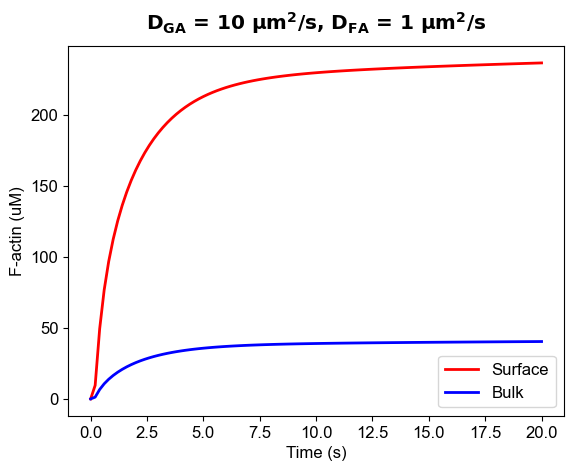

In [3]:
# location of the VCell output data
path = './Clus1_FAD_1'

# dt: time interval 
# Nx: Mesh elements count 
dt = 0.2
Nx = 64 

createDiffusionProfile('FA', path, dt=dt, dx=Nx-1)


### Concentration profile of G-actin

Files containing GA is 101


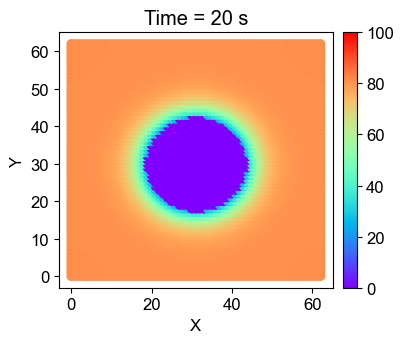

In [4]:
plotFrame('GA', path, idx=-1, dt=dt, dx=Nx-1) # last time frame

### Concentration profile of F-actin

Files containing FA is 101


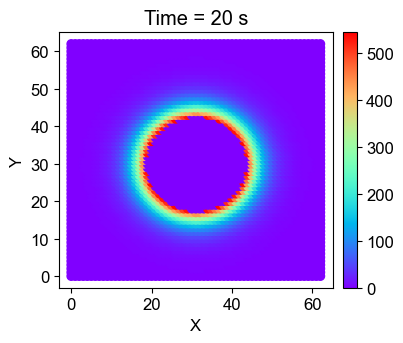

In [5]:
plotFrame('FA', path, idx=-1, dt=dt, dx=Nx-1) # last time frame